In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
predictors = pickle.load(open("pickle_jar/predictors.pkl", "rb"))
predictors = predictors[["gold", "crude_oil", "sp_interest", "debt_interest"]] #, "bit_cap"]]
predictors.tail()

,gold,crude_oil,sp_interest,debt_interest
2018-06-09,NaN,NaN,35.0,36.0
2018-06-10,NaN,NaN,27.0,34.0
2018-06-11,1296.05,66.10,27.0,34.0
2018-06-12,1298.30,66.36,27.0,34.0
2018-06-13,1294.40,66.64,27.0,34.0


In [3]:
sp = pd.read_csv("data/GSPC.csv")
sp["sp500"] = (sp.Close - sp.Open) / sp.Open * 100
sp = sp[["Date", "sp500"]]

In [4]:
t10 = pd.read_csv("data/T10Y2Y_CHG.csv")
t10["T10Y2Y"] = t10["T10Y2Y_CHG"].str.replace(".", "0").astype(float)

In [5]:
df = t10.merge(predictors, how="right", left_on="DATE", right_index = True)
df = df.merge(sp, how="inner", left_on="DATE", right_on="Date")
df.drop(["Date", "DATE", "T10Y2Y_CHG"], axis=1, inplace=True)

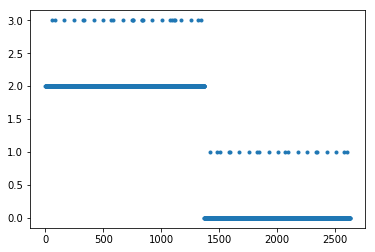

In [6]:
%matplotlib inline
df.isnull().sum(axis=1).plot(style=".")

In [11]:
data = df[1400:]
data.shape

(1230, 6)

In [30]:
val_slice = 900
test_slice = 1050

In [31]:
# Normalize via training data only
data = (data - data[:val_slice].mean()) / data[:val_slice].std() 

# FIll with 0's. Note: the LSTM should learn that 0's represent missing values
data.fillna(0, inplace=True) 

float_data = np.array(data)

In [32]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1] # -1 for the last var: sp500
        yield samples, targets

In [33]:
lookback = 20 # How many timesteps back the input data should go.
step = 1 # The period, in timesteps, at which you sample data. 
delay = 1 # How many timesteps in the future the target should be.
batch_size = 32 # Number big enough that it could be representatative of the whole 

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=val_slice,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=(val_slice+1),
                        max_index=test_slice,
                        step=step,
                        batch_size=batch_size)

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=test_slice+1,
                        max_index=None,
                        step=step,
                        batch_size=batch_size) #len(float_data) - (test_slice+1) )

val_steps = (test_slice - (val_slice+1) - lookback)
test_steps = (len(float_data) - (test_slice+1) - lookback)

In [34]:
print(val_steps, test_steps)
float_data.shape[-1] # number of variables

129 159


6

In [35]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [36]:
model = Sequential()
# Can replace GRU with  simple RNN or LTSM for experimentation.
model.add(layers.LSTM(16, input_shape=(None, float_data.shape[-1]) ))
                     # ,recurrent_dropout = .5, return_sequences=True))
#model.add(layers.LSTM(8))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [37]:
history = model.fit_generator(train_gen,
                            steps_per_epoch=16, # 
                            epochs=8, # passes through the training data
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            verbose=1)

Epoch 1/8
16/16 [==============================] - 6s 357ms/step - loss: 0.7372 - val_loss: 0.3655
Epoch 2/8
16/16 [==============================] - 4s 263ms/step - loss: 0.7186 - val_loss: 0.3486
Epoch 3/8
16/16 [==============================] - 4s 268ms/step - loss: 0.8120 - val_loss: 0.3495
Epoch 4/8
16/16 [==============================] - 4s 269ms/step - loss: 0.5875 - val_loss: 0.3450
Epoch 5/8
16/16 [==============================] - 4s 276ms/step - loss: 0.8036 - val_loss: 0.3445
Epoch 6/8
16/16 [==============================] - 5s 294ms/step - loss: 0.6518 - val_loss: 0.3483
Epoch 7/8
16/16 [==============================] - 5s 312ms/step - loss: 0.7455 - val_loss: 0.3460
Epoch 8/8
16/16 [==============================] - 5s 293ms/step - loss: 0.8241 - val_loss: 0.3477


In [38]:
preds = model.predict_generator(test_gen, test_steps)
preds.shape

(5088, 1)

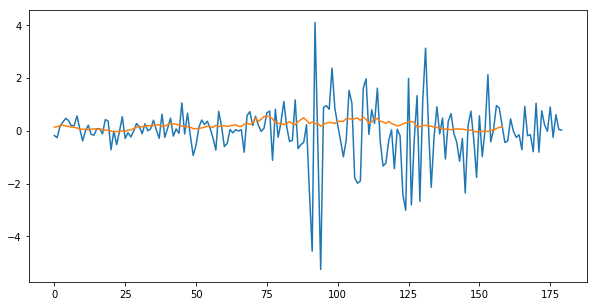

In [40]:
pd.Series(float_data[test_slice:, -1]).plot(figsize=(10,5))
pd.Series(preds[:test_steps, -1]).plot(figsize=(10,5))

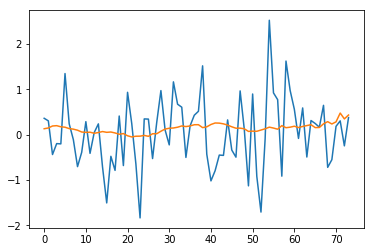

In [44]:
pd.Series(float_data[0:74, -1]).plot()
pd.Series(preds[0:74, -1]).plot()

In [56]:
a = pd.Series(float_data[0:74, -1])
b = pd.Series(preds[0:74, -1])
mae = ((a - b) ** 2).mean() ** .5
print("MAE: " + str(mae))
mav = ((float_data[0:74, -1]) ** 2).mean() ** .5
print("Mean Absolute Value: " + str(mav))

MAE: 0.768468345894
Mean Absolute Value: 0.767731542993


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fedaaefd630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fedab09c860>], dtype=object)

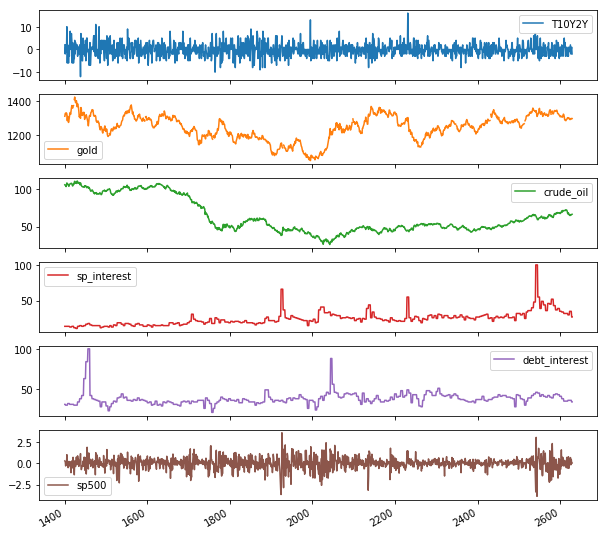

In [58]:
df[1400:].plot(subplots=True, figsize=(10, 10))